In [1]:
!pip install tensorflow-text
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install transformers rouge

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install matplotlib datasets pandas

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install nltk rouge_score

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import tensorflow as tf
import transformers
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

2024-02-26 03:59:28.996962: I tensorflow/core/tpu/tpu_api_dlsym_initializer.cc:95] Opening library: /usr/local/lib/python3.10/dist-packages/tensorflow/python/platform/../../libtensorflow_cc.so.2
2024-02-26 03:59:28.997271: I tensorflow/core/tpu/tpu_api_dlsym_initializer.cc:119] Libtpu path is: libtpu.so
2024-02-26 03:59:32.464944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric
from tqdm import tqdm

In [3]:
model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

In [4]:
cnn_dataset = load_dataset("cnn_dailymail", '3.0.0')

split_lengths = [len(cnn_dataset[split])for split in cnn_dataset]

print(f"Split lengths: {split_lengths}")
print(f"Features: {cnn_dataset['train'].column_names}")
print("\Article:")

print(cnn_dataset["test"][1]["article"])

print("\nSummary:")

print(cnn_dataset["test"][1]["highlights"])

Split lengths: [287113, 13368, 11490]
Features: ['article', 'highlights', 'id']
\Article:
(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguided mercy killing and then buried in a field -- only to survive. That's according to Washington State University, where the dog -- a friendly white-and-black bully breed mix now named Theia -- has been receiving care at the Veterinary Teaching Hospital. Four days after her apparent death, the dog managed to stagger to a nearby farm, dirt-covered and emaciated, where she was found by a worker who took her to a vet for help. She was taken in by Moses Lake, Washington, resident Sara Mellado. "Considering everything that she's been through, she's incredibly gentle and loving," Mellado said, according to WSU News. "She's a true miracle dog and she deserves a good life." Theia is only one year old but the dog's b

In [10]:
def prepare_data_for_histogram(dataset):
    highlight_lengths = [len(example['highlights'].split()) for example in dataset]
    article_lengths = [len(example['article'].split()) for example in dataset]
    return highlight_lengths, article_lengths

In [11]:
def plot_histograms(highlight_lengths, article_lengths):
    # Plot histogram for highlight lengths
    plt.figure(figsize=(12,  6))
    plt.hist(highlight_lengths, bins=50, alpha=0.5, label='Highlight Lengths')
    plt.title('Distribution of Highlight Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

    # Plot histogram for article lengths
    plt.figure(figsize=(12,  6))
    plt.hist(article_lengths, bins=50, alpha=0.5, label='Article Lengths')
    plt.title('Distribution of Article Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()


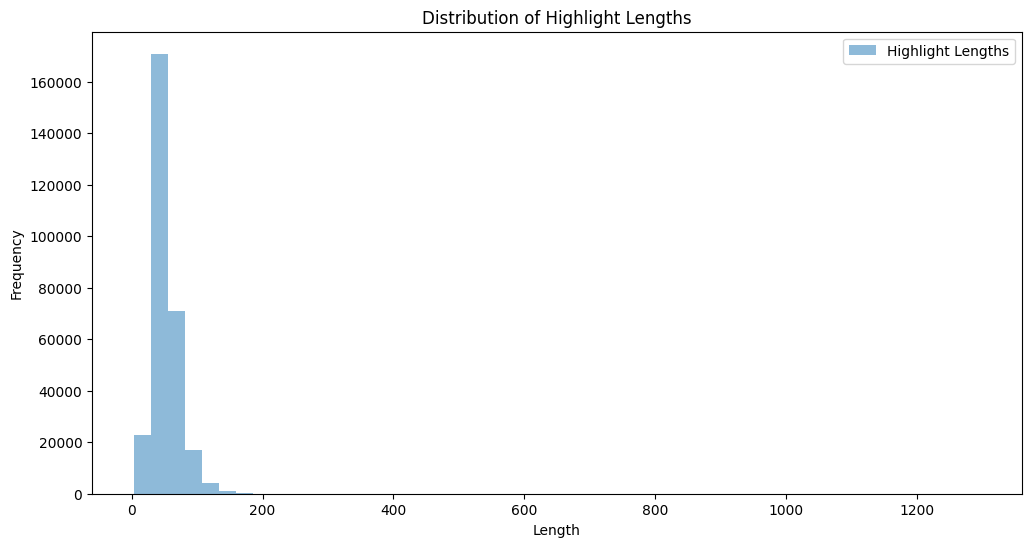

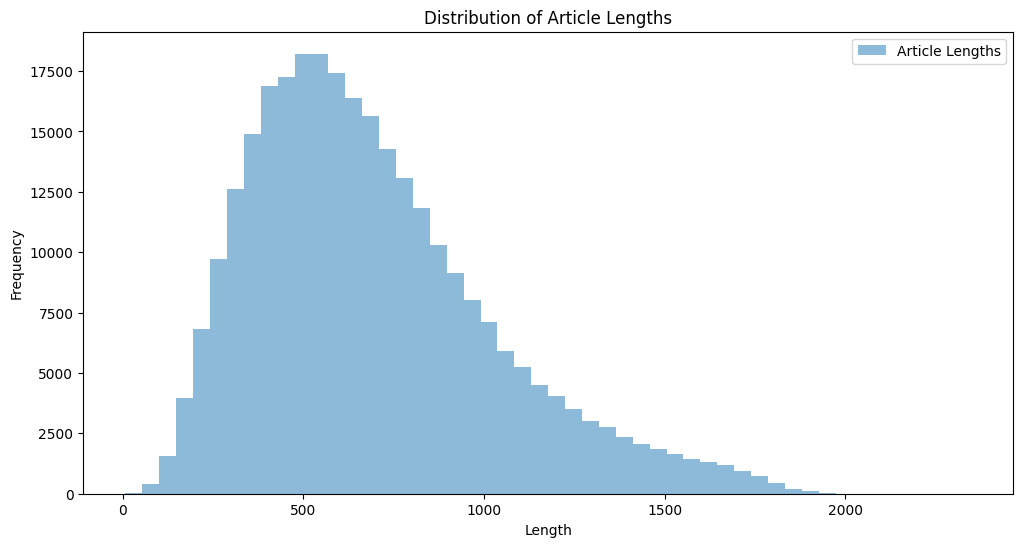

In [12]:
highlight_lengths, article_lengths = prepare_data_for_histogram(cnn_dataset["train"])
plot_histograms(highlight_lengths, article_lengths)

In [5]:
def filter_dataset_by_length(dataset, min_article_length=250, max_article_length=1000):
    # Filter the dataset
    filtered_dataset = dataset.filter(
        lambda example: min_article_length <= len(example['article'].split()) <= max_article_length
    )
    return filtered_dataset

In [6]:
filtered_train_dataset = filter_dataset_by_length(cnn_dataset['train'])
filtered_test_dataset = filter_dataset_by_length(cnn_dataset['test'])

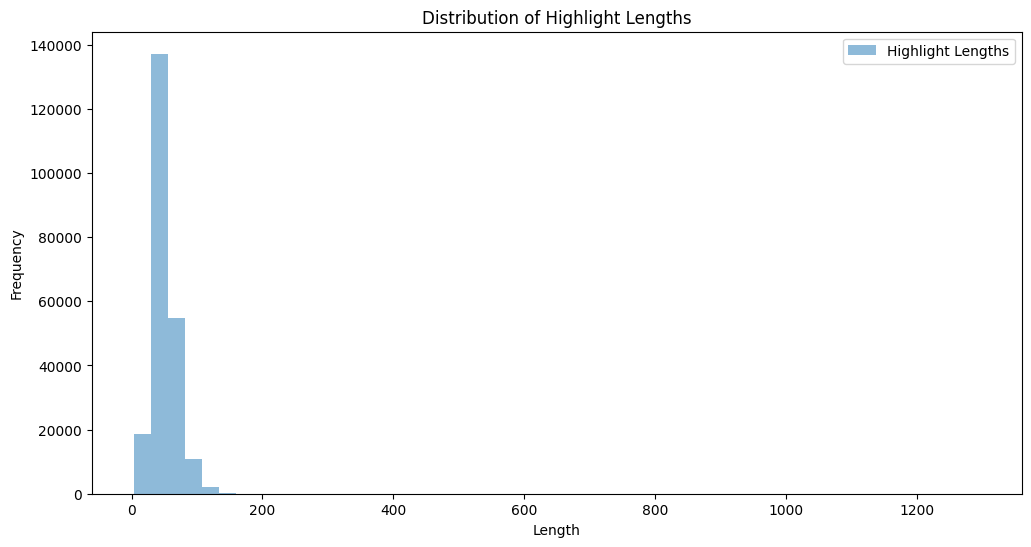

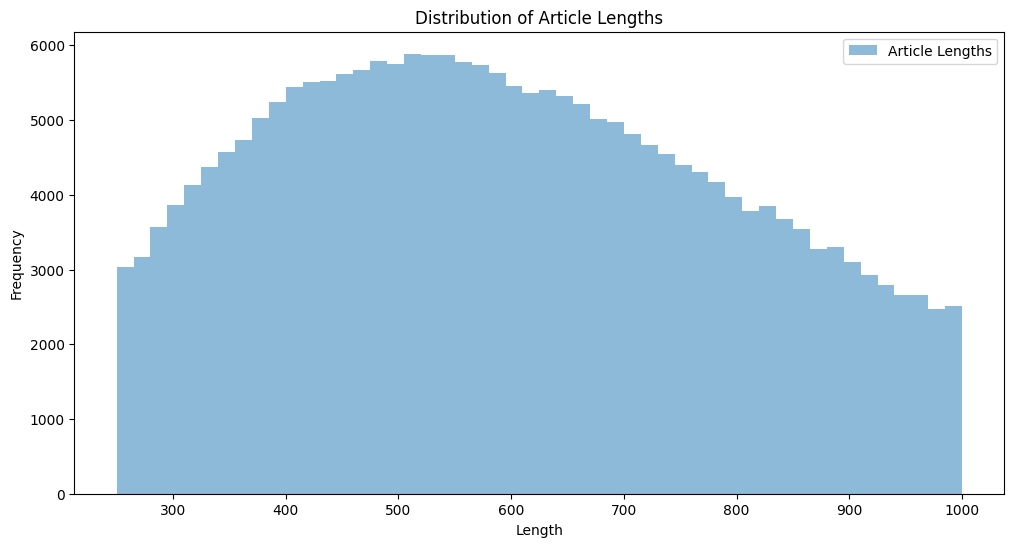

In [15]:
highlight_lengths, article_lengths = prepare_data_for_histogram(filtered_train_dataset)
plot_histograms(highlight_lengths, article_lengths)

In [7]:
#shuffle the filtered dataste
shuffled_dataset = filtered_train_dataset.shuffle(seed=42)
selected_100k_dataset = shuffled_dataset.select(range(5000))
len(selected_100k_dataset)

#shuffle test data
shuffled_test_dataset = filtered_test_dataset.shuffle(seed=42)
selected_2k_dataset = shuffled_test_dataset.select(range(2000))
len(selected_2k_dataset)

2000

In [17]:
import tensorflow as tf

# List all logical devices
devices = tf.config.list_logical_devices()

# Print the names of all devices
for device in devices:
    print(f"Device: {device.name}, Type: {device.device_type}")


Device: /device:CPU:0, Type: CPU
Device: /device:TPU:0, Type: TPU
Device: /device:TPU:1, Type: TPU
Device: /device:TPU:2, Type: TPU
Device: /device:TPU:3, Type: TPU
Device: /device:TPU:4, Type: TPU
Device: /device:TPU:5, Type: TPU
Device: /device:TPU:6, Type: TPU
Device: /device:TPU:7, Type: TPU
Device: /device:TPU_SYSTEM:0, Type: TPU_SYSTEM


2024-02-25 17:35:38.518821: I external/local_xla/xla/service/service.cc:168] XLA service 0x55d8aa4b4000 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2024-02-25 17:35:38.518874: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): TPU, 2a886c8
2024-02-25 17:35:38.518885: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): TPU, 2a886c8
2024-02-25 17:35:38.518895: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): TPU, 2a886c8
2024-02-25 17:35:38.518904: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): TPU, 2a886c8
2024-02-25 17:35:38.518914: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (4): TPU, 2a886c8
2024-02-25 17:35:38.518923: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (5): TPU, 2a886c8
2024-02-25 17:35:38.518932: I external/local_xla/xla/service/service.cc:176]   StreamExecutor d

In [8]:
pipe = pipeline('summarization', model = model_name )

pipe_out = pipe(cnn_dataset['test'][0]['article'] )


print(pipe_out)

RuntimeError: Failed to import transformers.models.pegasus.modeling_tf_pegasus because of the following error (look up to see its traceback):
No module named 'keras.engine'

In [11]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [12]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"],
                         attention_mask=inputs["attention_mask"],
                         length_penalty=0.8, num_beams=8, max_length=250)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [13]:
selected_three_dataset = shuffled_test_dataset.select(range(10))
selected_three_dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 10
})

In [22]:
rouge_metric = load_metric('rouge')

r_score = calculate_metric_on_test_ds(selected_three_dataset, rouge_metric, model, tokenizer, column_text = 'article', column_summary='highlights', batch_size=8)


/tmp/ipykernel_19024/1931114932.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
/home/sid/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████████████| 2/2 [01:35<00:00, 47.86s/it]


In [23]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, r_score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict,index=['pre_trained_pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pre_trained_pegasus,0.005839,0.0,0.005717,0.005714


In [14]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['article'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['highlights'], max_length = 250, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_cnn_pt = selected_100k_dataset.map(convert_examples_to_features, batched = True)
     

In [15]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [16]:
filtered_validation_dataset = filter_dataset_by_length(cnn_dataset['validation'])
filtered_validation_dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 10335
})

In [17]:
#shuffle the filtered dataste
shuffled_validation_dataset = filtered_validation_dataset.shuffle(seed=42)
selected_10k_dataset = shuffled_validation_dataset.select(range(2000))

In [18]:
dataset_cnn_validation_pt = selected_10k_dataset.map(convert_examples_to_features, batched = True)

In [19]:
dataset_cnn_validation_pt

Dataset({
    features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2000
})

In [20]:

from transformers import TFTrainingArguments, Trainer

trainer_args = TFTrainingArguments(
    output_dir='pegasus-cnn', num_train_epochs=1, warmup_steps=250,
    per_device_train_batch_size=16, per_device_eval_batch_size=8,
    weight_decay=0.01, logging_steps=100,logging_dir="./logs",
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=8,
    tpu_num_cores=8,
) 

In [21]:
trainer = Trainer(model=model, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_cnn_pt, 
                  eval_dataset=dataset_cnn_validation_pt)
     

/home/sid/.local/lib/python3.10/site-packages/transformers/training_args_tf.py:291: FutureWarning: The n_gpu argument is deprecated and will be removed in a future version, use n_replicas instead.
  warnings.warn(
2024-02-26 04:02:28.792866: I external/local_xla/xla/service/service.cc:168] XLA service 0x55ea8a8c8000 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2024-02-26 04:02:28.792903: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): TPU, 2a886c8
2024-02-26 04:02:28.792915: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): TPU, 2a886c8
2024-02-26 04:02:28.792925: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): TPU, 2a886c8
2024-02-26 04:02:28.792934: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): TPU, 2a886c8
2024-02-26 04:02:28.792943: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (4): TPU, 2a886c8


In [ ]:
trainer.train()

/home/sid/.local/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/sid/.local/lib/python3.10/site-packages/transformers/training_args_tf.py:291: FutureWarning: The n_gpu argument is deprecated and will be removed in a future version, use n_replicas instead.
  warnings.warn(


Step,Training Loss,Validation Loss


In [ ]:

score = calculate_metric_on_test_ds(
    selected_2k_dataset, rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'article', column_summary= 'highlights'
)
 
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

In [ ]:
model_pegasus.save_pretrained("pegasus-cnn-model")